<a href="https://colab.research.google.com/github/baoquan25/luongducminh/blob/main/D%E1%BB%B1_%C4%91o%C3%A1n_gi%C3%A1_ch%E1%BB%A9ng_kho%C3%A1n_(2_%C4%91%E1%BA%A7u_v%C3%A0o_close_v%C3%A0_volume).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

! pip install vnstock3
from vnstock3 import Vnstock

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Nhập cổ phiếu cần dự đoán

In [ ]:
stock = Vnstock().stock(symbol ='PAC', source= 'VCI')
stock = stock.quote.history(start ='2018-01-01', end ='2024-12-30')
stock = stock.sort_values(by='time')
stock['year'] = stock['time'].dt.year
stock = pd.DataFrame(stock[['time','close','volume']])
stock['close']= stock['close']
stock

2024-12-31 03:36:59 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


,time,close,volume
0,2018-01-02,32.42,59500
1,2018-01-03,32.09,73000
2,2018-01-04,32.35,113390
3,2018-01-05,32.42,47910
4,2018-01-08,32.29,65610
...,...,...,...
1745,2024-12-25,43.00,669743
1746,2024-12-26,43.35,586268
1747,2024-12-27,43.00,324407
1748,2024-12-30,41.55,404160


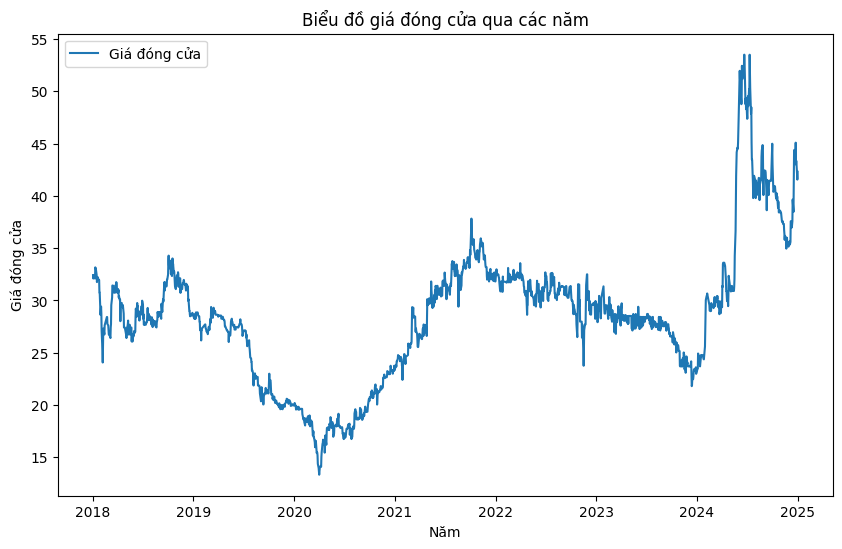

In [ ]:
# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 6))
plt.plot(stock['time'],stock['close'], label='Giá đóng cửa')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa qua các năm')
plt.legend()

In [ ]:
#xử lý dữ liệu
stock1 = stock.set_index('time')
stock1

,close,volume
time,,
2018-01-02,32.42,59500
2018-01-03,32.09,73000
2018-01-04,32.35,113390
2018-01-05,32.42,47910
2018-01-08,32.29,65610
...,...,...
2024-12-25,43.00,669743
2024-12-26,43.35,586268
2024-12-27,43.00,324407


## **Xử lý dữ liệu để đưa vào mô hình**

In [ ]:
#chia tập dữ liệu
data = stock1.values
train_data = data[:1300]
test_data = data[1300:]

In [ ]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [ ]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,:]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) # Dự đoán giá trị 'close' (cột đầu tiên)

In [ ]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [ ]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào

#lớp 1 LSTM
model.add(LSTM(units=128 ,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)

#Lớp 2 LSTM
model.add(LSTM(units=64))
model.add(Dropout(0.2)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)

model.add(Dense(1)) #output đầu ra 1 chiều

#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [ ]:
#huấn luyện mô hình
save_model = "/content/drive/MyDrive/model2.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.06998, saving model to /content/drive/MyDrive/model2.keras
25/25 - 7s - 260ms/step - loss: 0.0700
Epoch 2/100

Epoch 2: loss improved from 0.06998 to 0.03175, saving model to /content/drive/MyDrive/model2.keras
25/25 - 5s - 192ms/step - loss: 0.0318
Epoch 3/100

Epoch 3: loss improved from 0.03175 to 0.03046, saving model to /content/drive/MyDrive/model2.keras
25/25 - 7s - 287ms/step - loss: 0.0305
Epoch 4/100

Epoch 4: loss improved from 0.03046 to 0.02945, saving model to /content/drive/MyDrive/model2.keras
25/25 - 3s - 121ms/step - loss: 0.0295
Epoch 5/100

Epoch 5: loss improved from 0.02945 to 0.02805, saving model to /content/drive/MyDrive/model2.keras
25/25 - 5s - 204ms/step - loss: 0.0281
Epoch 6/100

Epoch 6: loss improved from 0.02805 to 0.02648, saving model to /content/drive/MyDrive/model2.keras
25/25 - 6s - 238ms/step - loss: 0.0265
Epoch 7/100

Epoch 7: loss improved from 0.02648 to 0.02621, saving model to /content/drive/

In [ ]:
#dữ liệu train
y_train_full = np.column_stack([y_train, np.zeros_like(y_train)])  # Thêm cột volume giả (có thể là 0)
y_train = sc.inverse_transform(y_train_full) #giá thực
y_train = y_train_full[:, 0]  # Lấy cột 'close' sau khi phục hồi

# Tải mô hình đã huấn luyện
final_model = load_model("/content/drive/MyDrive/model2.keras")

# Dự đoán giá trị trên tập huấn luyện
y_train_predict = final_model.predict(x_train)

# Phục hồi giá trị dự đoán từ chuẩn hóa (y_train_predict là 2D)
y_train_predict_full = np.column_stack([y_train_predict, np.zeros_like(y_train_predict)])

y_train_predict = y_train_predict_full[:, 0] # Lấy cột 'close' sau khi phục hồi

y_train_predict_full_2D = y_train_predict_full.reshape(-1, 2)

# Khôi phục giá trị
y_train_predict_restored_full = sc.inverse_transform(y_train_predict_full_2D)

# Lấy lại cột đầu tiên (cột "close" ban đầu)
y_train_predict = y_train_predict_restored_full[:, 0]

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step


In [ ]:
#xử lý dữ liệu test
test = stock1[len(train_data)-50:]  # Lấy phần dữ liệu từ DataFrame

# Loại bỏ các hàng chứa NaT trong test trước khi áp dụng transform
# Thay thế np.isnan bằng pd.isnull để xử lý các kiểu dữ liệu khác, bao gồm cả NaT
test = test[~pd.isnull(test).any(axis=1)]
test = test.values
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,:])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2]))

#dữ liệu test
y_test = data[1300:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict_full = np.column_stack([y_test_predict, np.zeros_like(y_test_predict)])
y_test_predict = sc.inverse_transform(y_test_predict_full)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


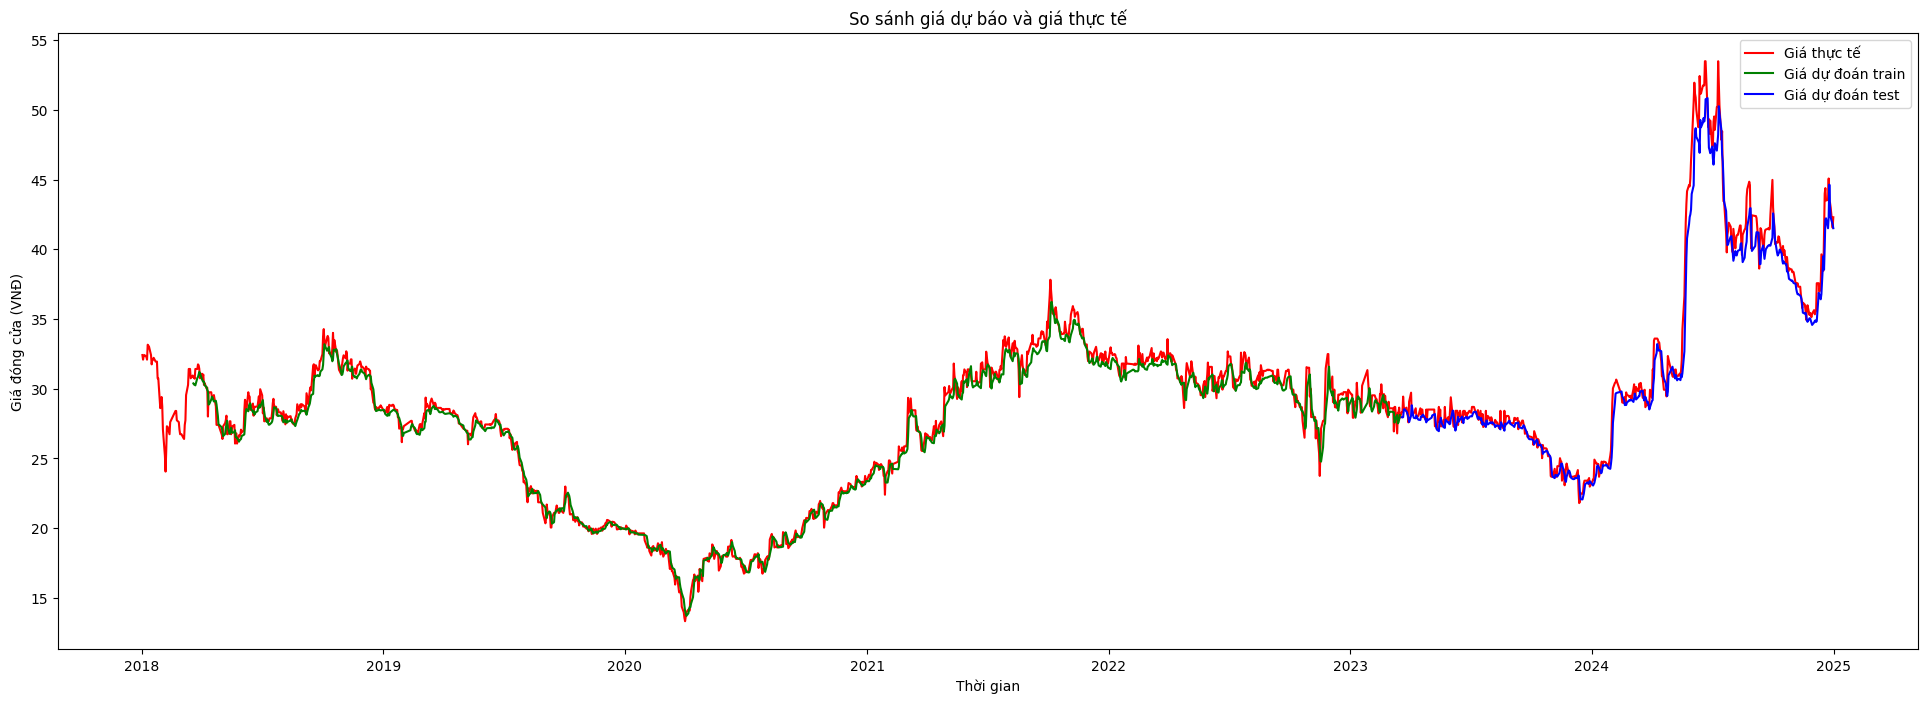

In [ ]:
#lập biểu đồ so sánh
train_data1 = stock1[50:1300]
test_data1 = stock1[1300:]

plt.figure(figsize=(24,8))
plt.plot(stock1['close'],label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test

plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

Nhập số ngày muốn dự đoán: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


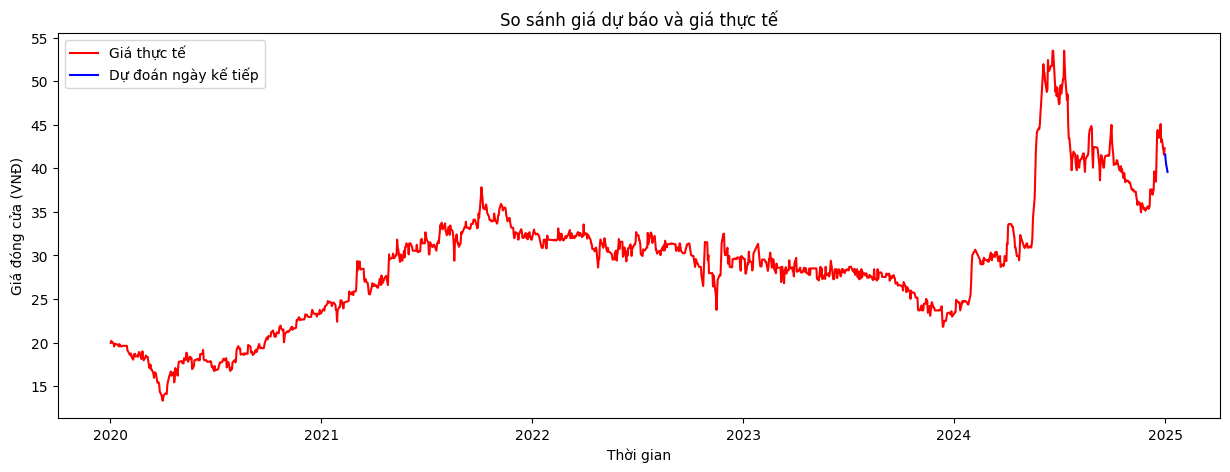

,time,close,volume
1749,2024-12-31,42.300000,307800.0
1750,2025-01-01,41.583270,NaN
1751,2025-01-02,40.792614,NaN
1752,2025-01-03,40.325218,NaN
1753,2025-01-04,39.966648,NaN
1754,2025-01-05,39.579853,NaN


In [ ]:
date = int(input("Nhập số ngày muốn dự đoán: "))

# Tạo danh sách ngày tiếp theo
next_date = [stock['time'].iloc[-1] + pd.Timedelta(days=i+1) for i in range(date)]
next_date = pd.to_datetime(next_date)

# Lấy dữ liệu đầu vào từ cột close và volume, chuẩn hóa
x_next = sc_train[-50:, :].reshape(1, 50, 2)  # Lấy 50 giá trị gần nhất, định dạng 3D
predicted_prices = []  # Danh sách để lưu giá trị dự đoán

for i in range(date):
    # Dự đoán giá trị ngày tiếp theo
    y_next_predict = final_model.predict(x_next)

    # Đưa giá trị dự đoán ngược lại thành giá trị gốc
    y_next_predict_full = np.column_stack([y_next_predict, np.zeros((y_next_predict.shape[0], 1))])  # Giữ volume = 0
    y_next_predict_full = sc.inverse_transform(y_next_predict_full)
    y_next_predict_value = y_next_predict_full[0, 0]

    # Lưu giá trị dự đoán
    predicted_prices.append(y_next_predict_value)

    # Cập nhật dữ liệu x_next cho lần lặp tiếp theo
    next_row = np.array([[y_next_predict[0, 0], 0]])  # Chỉ cập nhật close, giữ volume là 0
    x_next = np.vstack([x_next[0, 1:, :], next_row]).reshape(1, 50, 2)

# Thêm dữ liệu dự đoán vào DataFrame
stock_next = pd.DataFrame({'time': next_date, 'close': predicted_prices})
stock1 = pd.concat([stock, stock_next], ignore_index=True)


# Vẽ biểu đồ với dự đoán của 5 ngày kế tiếp
stock_filtered = stock1[(stock1['time'] >= '2020-01-01') & (stock1['time'] <= '2024-12-31')]
plt.figure(figsize=(15, 5))
plt.plot(stock_filtered['time'], stock_filtered['close'], label='Giá thực tế', color='red')
plt.plot(next_date, predicted_prices, color='blue', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()

stock1.tail(date+1)